In [ ]:
import pandas as pd
import numpy as np

#Loading the Data

In [ ]:
data = pd.read_csv('/content/train_data_v2.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

#Data Exploratory Analysis

In [ ]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


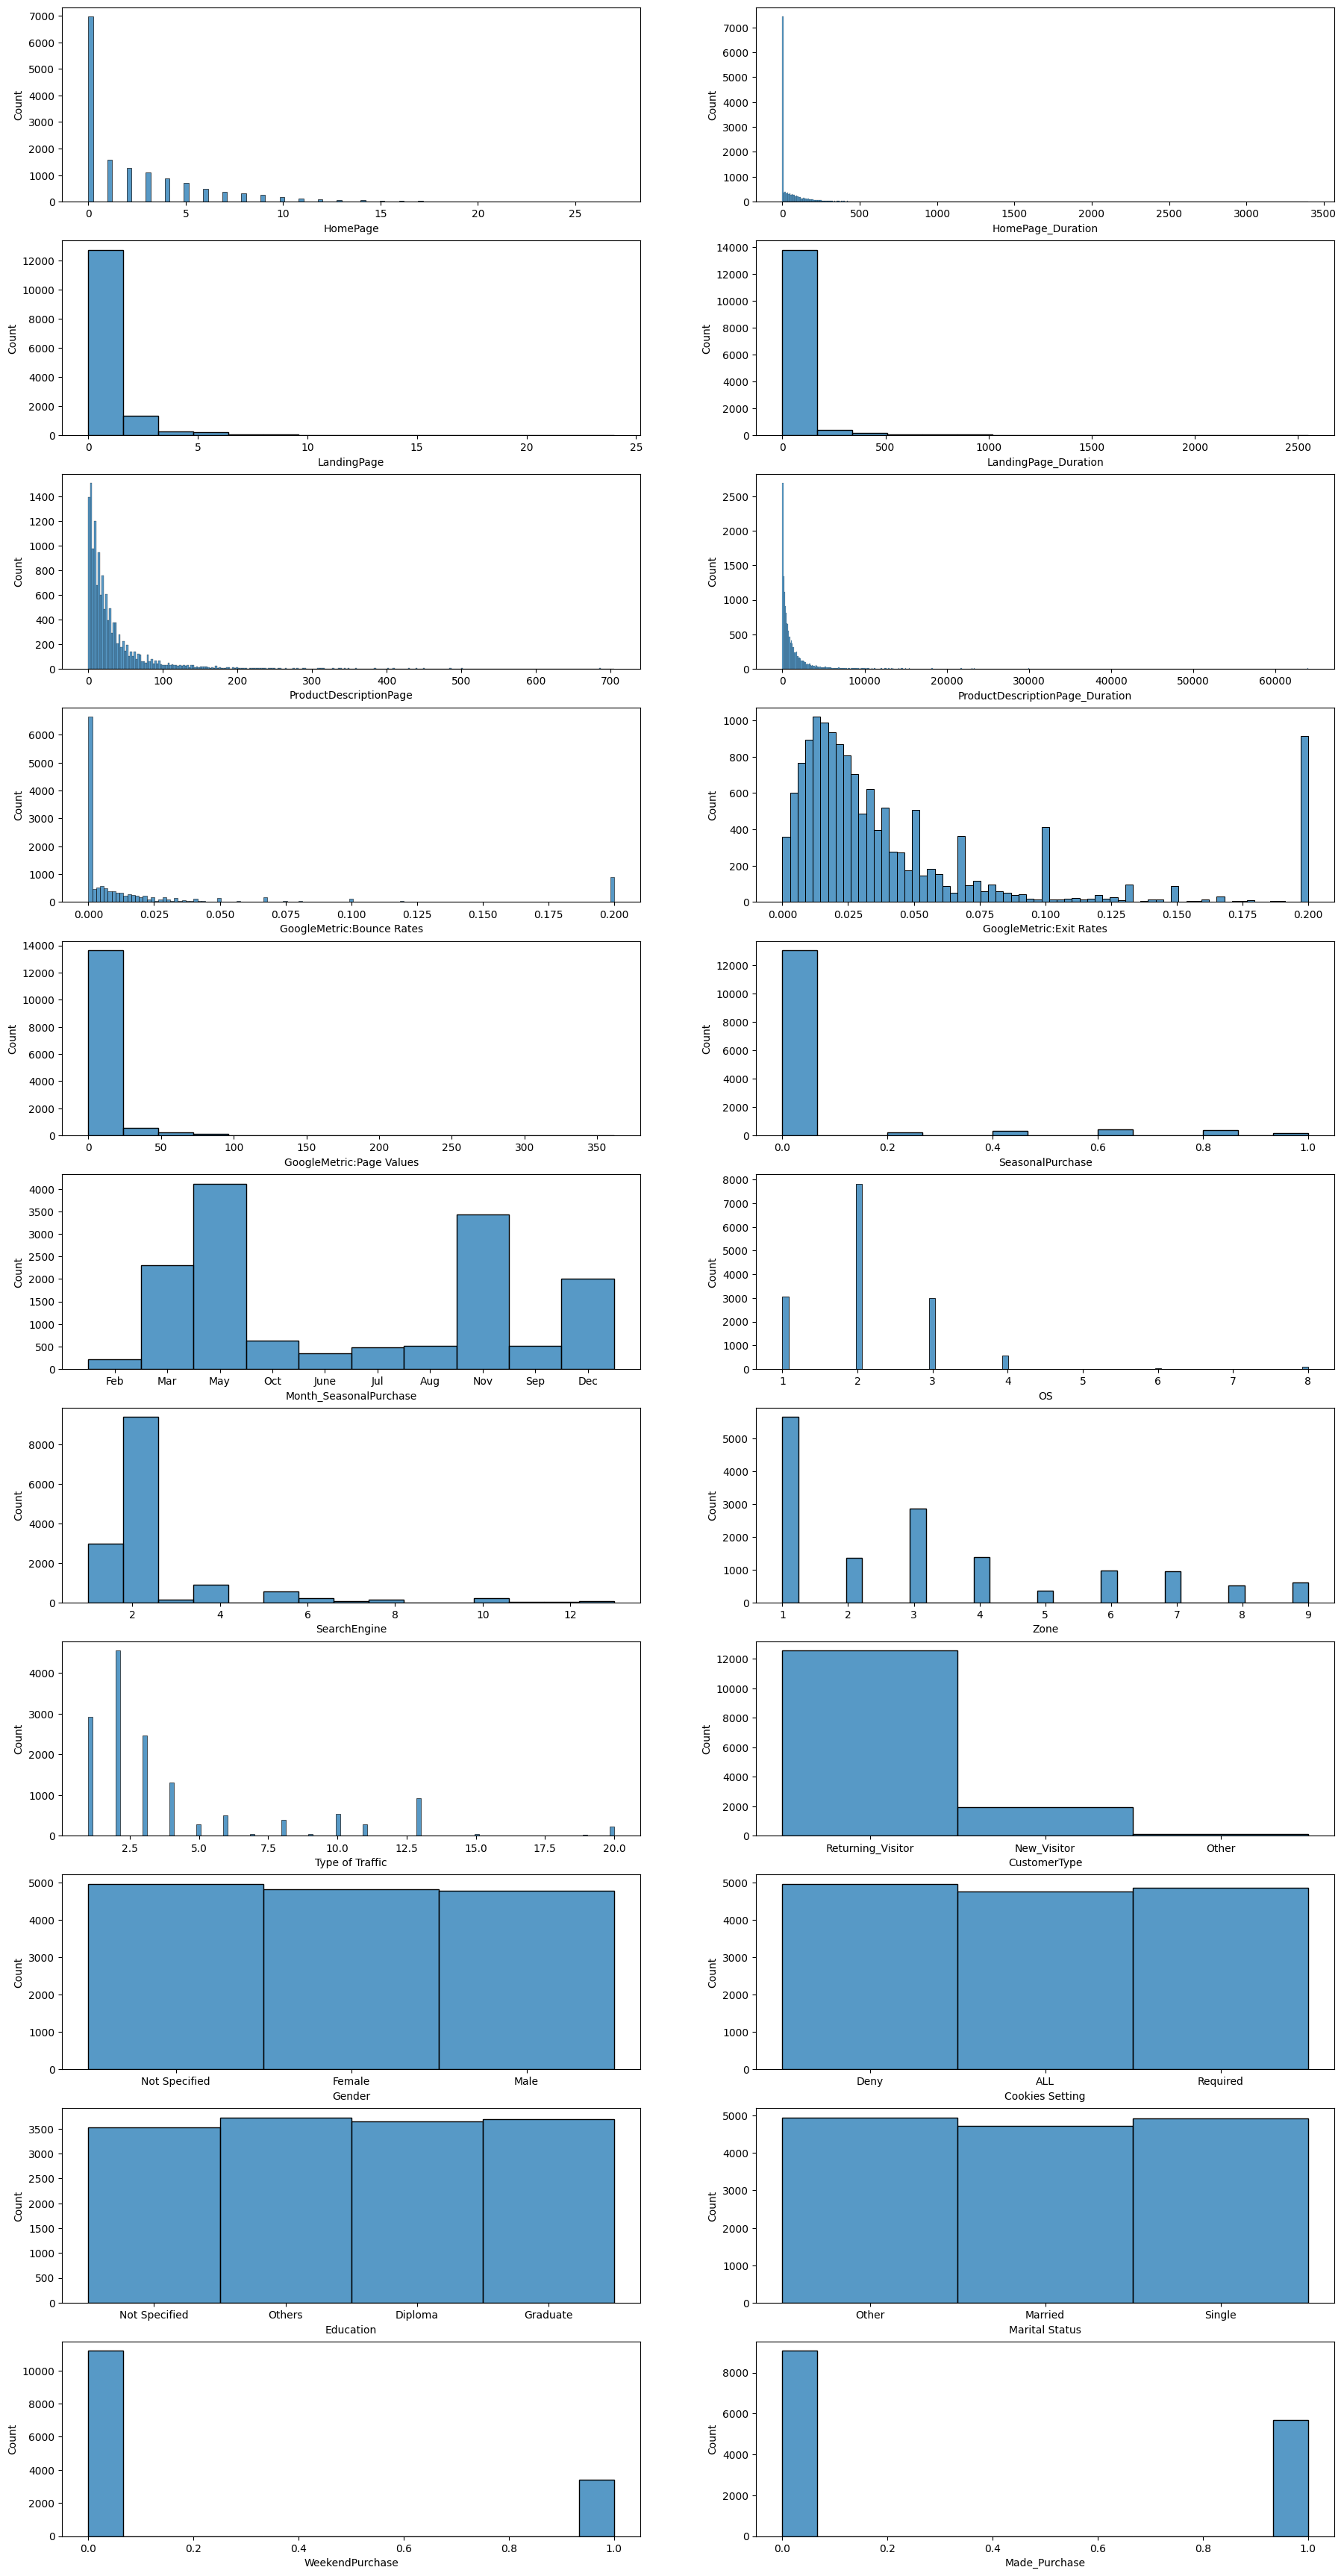

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
features = data.columns
plt.figure(figsize=(22,44))
i = 1
for feature in features:
    plt.subplot(11,2,i)
    sns.histplot(data[feature])
    i += 1


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest

In [ ]:
num_pipe = ColumnTransformer([('scaler', MinMaxScaler(), [0,1,2,3,4,5,6,7,8,9,11,12,13,14,20])])
cat_pipe = ColumnTransformer([('label',OrdinalEncoder(),[10,15,16,17,18,19])])
feature = FeatureUnion(transformer_list = [('numerical', num_pipe),
                                           ('categorical',cat_pipe)])
preprocess_pipe = Pipeline([('encode', feature),
                            ('impute', ColumnTransformer([('imputer', SimpleImputer(missing_values = np.nan,
                                                                                    strategy = 'most_frequent'), slice(0,20))]))
                            ])

In [ ]:
X = preprocess_pipe.fit_transform(X,y)


In [ ]:
oe = OrdinalEncoder()
y = oe.fit_transform(y.to_numpy().reshape(-1,1))


##Over Sampling the UnderSampled Class.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X,y)
counter = Counter(y_sm)
counter

Counter({0.0: 9065, 1.0: 9065})

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression(penalty = 'l2')
logis.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
logis.score(X_sm,y_sm)

0.5614451185879757

In [ ]:
from sklearn.metrics import classification_report
y_pred = logis.predict(X_sm)
print(classification_report(y_sm, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.96      0.69      9065
         1.0       0.81      0.16      0.27      9065

    accuracy                           0.56     18130
   macro avg       0.67      0.56      0.48     18130
weighted avg       0.67      0.56      0.48     18130



#RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_sm, y_sm)

RandomForestClassifier()

In [ ]:
rfc.score(X_sm, y_sm) #Given 0.84 accuracy.

0.8404853833425262

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_sm,rfc.predict(X_sm)))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      9065
         1.0       0.87      0.80      0.83      9065

    accuracy                           0.84     18130
   macro avg       0.84      0.84      0.84     18130
weighted avg       0.84      0.84      0.84     18130



##Using GridSearchCV to perform hyperparameter Tuning

In [ ]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

param_grid = {'max_depth': range(5,20),
              'min_samples_split': range(2, 8)}
dt_grid_search = GridSearchCV(RandomForestClassifier(),
                              param_grid=param_grid,
                              n_jobs=2,
                              cv=cv,
                              scoring='neg_mean_absolute_error',
                              return_train_score=True)
dt_grid_search.fit(X_sm, y_sm)

##Gridsearchcv given less accuracy of 0.80

In [ ]:
test_data=pd.read_csv("/content/test_data_v2.csv")

In [ ]:
test_data.info()

In [ ]:
x_test= test_data[test_data.columns[:-1]]
y_test= test_data[test_data.columns[-1]]

In [ ]:
y_test

In [ ]:
x_test.columns

In [ ]:
skb = SelectKBest(k=15)

x_trans = preprocess_pipe.transform(x_test)
X = skb.fit_transform(x_trans,y_test)

In [ ]:
oe = OrdinalEncoder()
y_test_transformed=oe.fit_transform(y_test.to_numpy().reshape(-1,1))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,rfc.predict(x_test_transformed)))